# Transpilation 

## Backend Creation

In ```/src/backend_utils/mock_backends```, target topologies are created by implementing ```ConfigurableFakeBackendV2``` which is an abstract class defined in ```src/backend_utils/configurable_backend_v2.py```

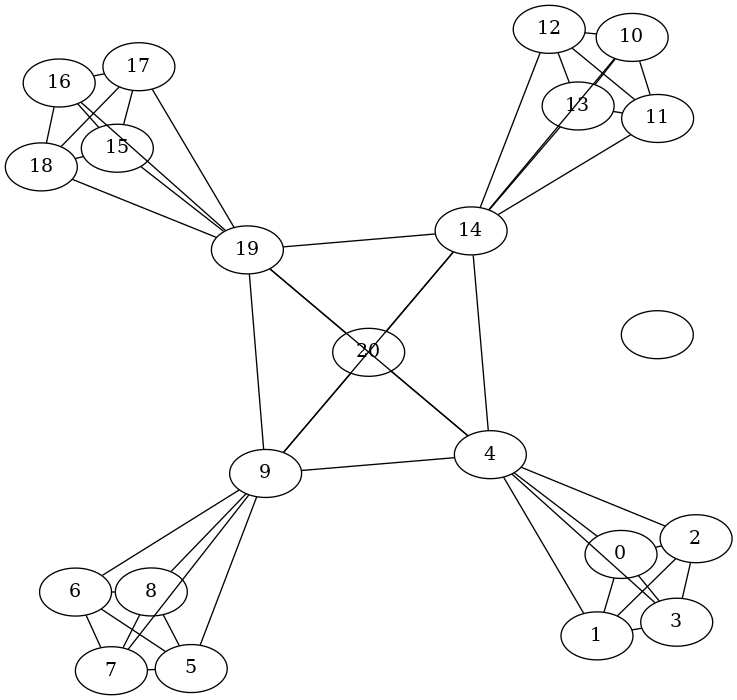

In [1]:
from src.backend_utils.topology_visualization import pretty_print
from src.backend_utils.mock_backends import FakeModular
pb = FakeModular(module_size=5, children=4, total_levels=2)
pretty_print(pb)

## Decomposition Transpiler Pass
The pass manager for data collection is defined in ```/src/utils/transpiler_passes/pass_manager_v3.py```, which needs additional decomposition passes for $\sqrt{\texttt{iSwap}}$ and $\texttt{SYC}$ gates. Next, we test the $\sqrt{\texttt{iSwap}}$ pass by showing that it's Haar score tends to 2.21 as expected

In [2]:
from qiskit.quantum_info.random import random_unitary
from qiskit import QuantumCircuit
from src.utils.riswap_gates.riswap import RiSwapGate
from src.utils.transpiler_passes.weyl_decompose import RootiSwapWeylDecomposition
from qiskit.transpiler.passes import CountOps
from qiskit.transpiler import PassManager
from tqdm import tqdm

N = 2000
basis_gate = RiSwapGate(0.5)

pm0 = PassManager()
pm0.append(RootiSwapWeylDecomposition(basis_gate=basis_gate))
pm0.append(CountOps())

res = 0 
for _ in tqdm(range(N)):
    qc = QuantumCircuit(2)
    qc.append(random_unitary(dims=4), [0,1])
    pm0.run(qc)
    res += pm0.property_set['count_ops']['riswap']
print("Haar score:", res/N)

100%|██████████| 2000/2000 [00:11<00:00, 169.71it/s]

Haar score: 2.223


## Creating a Benchmark
We need to define the circuits, circuit sizes, topologies, and basis gates we want to transpile to and plot results for. We do this by wrapping the backend object and its transpiler pass manager into an object that handles data collection in ```src/benchmark_suite/backend_suite_v3.py```. The set used for data collection in the paper are in ```src/benchmark_suite/backend_suite_v2.py```. The relevant change is that 'v3' uses a slightly more optimized pass manager (optimized for time).

In [3]:
from src.benchmark_suite.backend_suite_v3 import simple_backends_v3
print([backend.label for backend in simple_backends_v3])

['Heavy-Hex-cx-smallv3', 'Square-Lattice-syc-smallv3', 'Modular-riswap-smallv3', 'Corral-8-(0, 0)-riswap-smallv3']


Note: There is a bug in the current version of Supermarq for making QAOA_Vanilla circuit. To fix in interm, comment out ```supermarq/benchmarks/qaoa_vanilla_proxy.py```, line 76: ```circuit.append(cirq.measure(*qubits))```

We do
```python 
#self.params = self._gen_angles()
self.params = np.random.uniform(size=2) * 2 * np.pi
```

In [27]:
from src.benchmark_suite.circuit_suite import circuits
q_size = 4
circuits["QAOA_Vanilla"].circuit_lambda(q_size).decompose().draw()

global phase: 5.36
     ┌─────────┐                                                        »
q_0: ┤ U2(0,π) ├───────────────────────────■────────────────────■───────»
     ├─────────┤                           │                    │       »
q_1: ┤ U2(0,π) ├───────────────────────────┼────────────────────┼────■──»
     ├─────────┤                           │                    │    │  »
q_2: ┤ U2(0,π) ├──■───────────────────■────┼────────────────────┼────┼──»
     ├─────────┤┌─┴─┐┌─────────────┐┌─┴─┐┌─┴─┐┌──────────────┐┌─┴─┐┌─┴─┐»
q_3: ┤ U2(0,π) ├┤ X ├┤ U1(0.46159) ├┤ X ├┤ X ├┤ U1(-0.46159) ├┤ X ├┤ X ├»
     └─────────┘└───┘└─────────────┘└───┘└───┘└──────────────┘└───┘└───┘»
«                                                                 »
«q_0: ─────────────────────────────────────────────────────────■──»
«                                                            ┌─┴─┐»
«q_1: ─────────────────■─────────■────────────────────────■──┤ X ├»
«                      │       ┌─┴─┐     ┌─────────────┐┌─┴─┐└───┘»
«q_2: ─────────────────┼───────┤ X ├─────┤ U1(0.46159) ├┤ X ├─────»
«     ┌─────────────┐┌─┴─┐┌────┴───┴────┐└─────────────┘└───┘     »
«q_3: ┤ U1(0.46159) ├┤ X ├┤ R(2.6991,0) ├─────────────────────────»
«     └─────────────┘└───┘└─────────────┘                         »
«                                                  ┌─────────────┐
«q_0: ─────────────────■────■───────────────────■──┤ R(2.6991,0) ├
«     ┌─────────────┐┌─┴─┐  │  ┌─────────────┐  │  └─────────────┘
«q_1: ┤ U1(0.46159) ├┤ X ├──┼──┤ R(2.6991,0) ├──┼─────────────────
«     └─────────────┘└───┘┌─┴─┐├─────────────┤┌─┴─┐┌─────────────┐
«q_2: ────────────────────┤ X ├┤ U1(0.46159) ├┤ X ├┤ R(2.6991,0) ├
«                         └───┘└─────────────┘└───┘└─────────────┘
«q_3: ────────────────────────────────────────────────────────────
«

Starting benchmark for Quantum_Volume
Starting benchmark for QFT
Starting benchmark for QAOA_Vanilla
Starting benchmark for TIM_Hamiltonian
Starting benchmark for Adder
Starting benchmark for GHZ


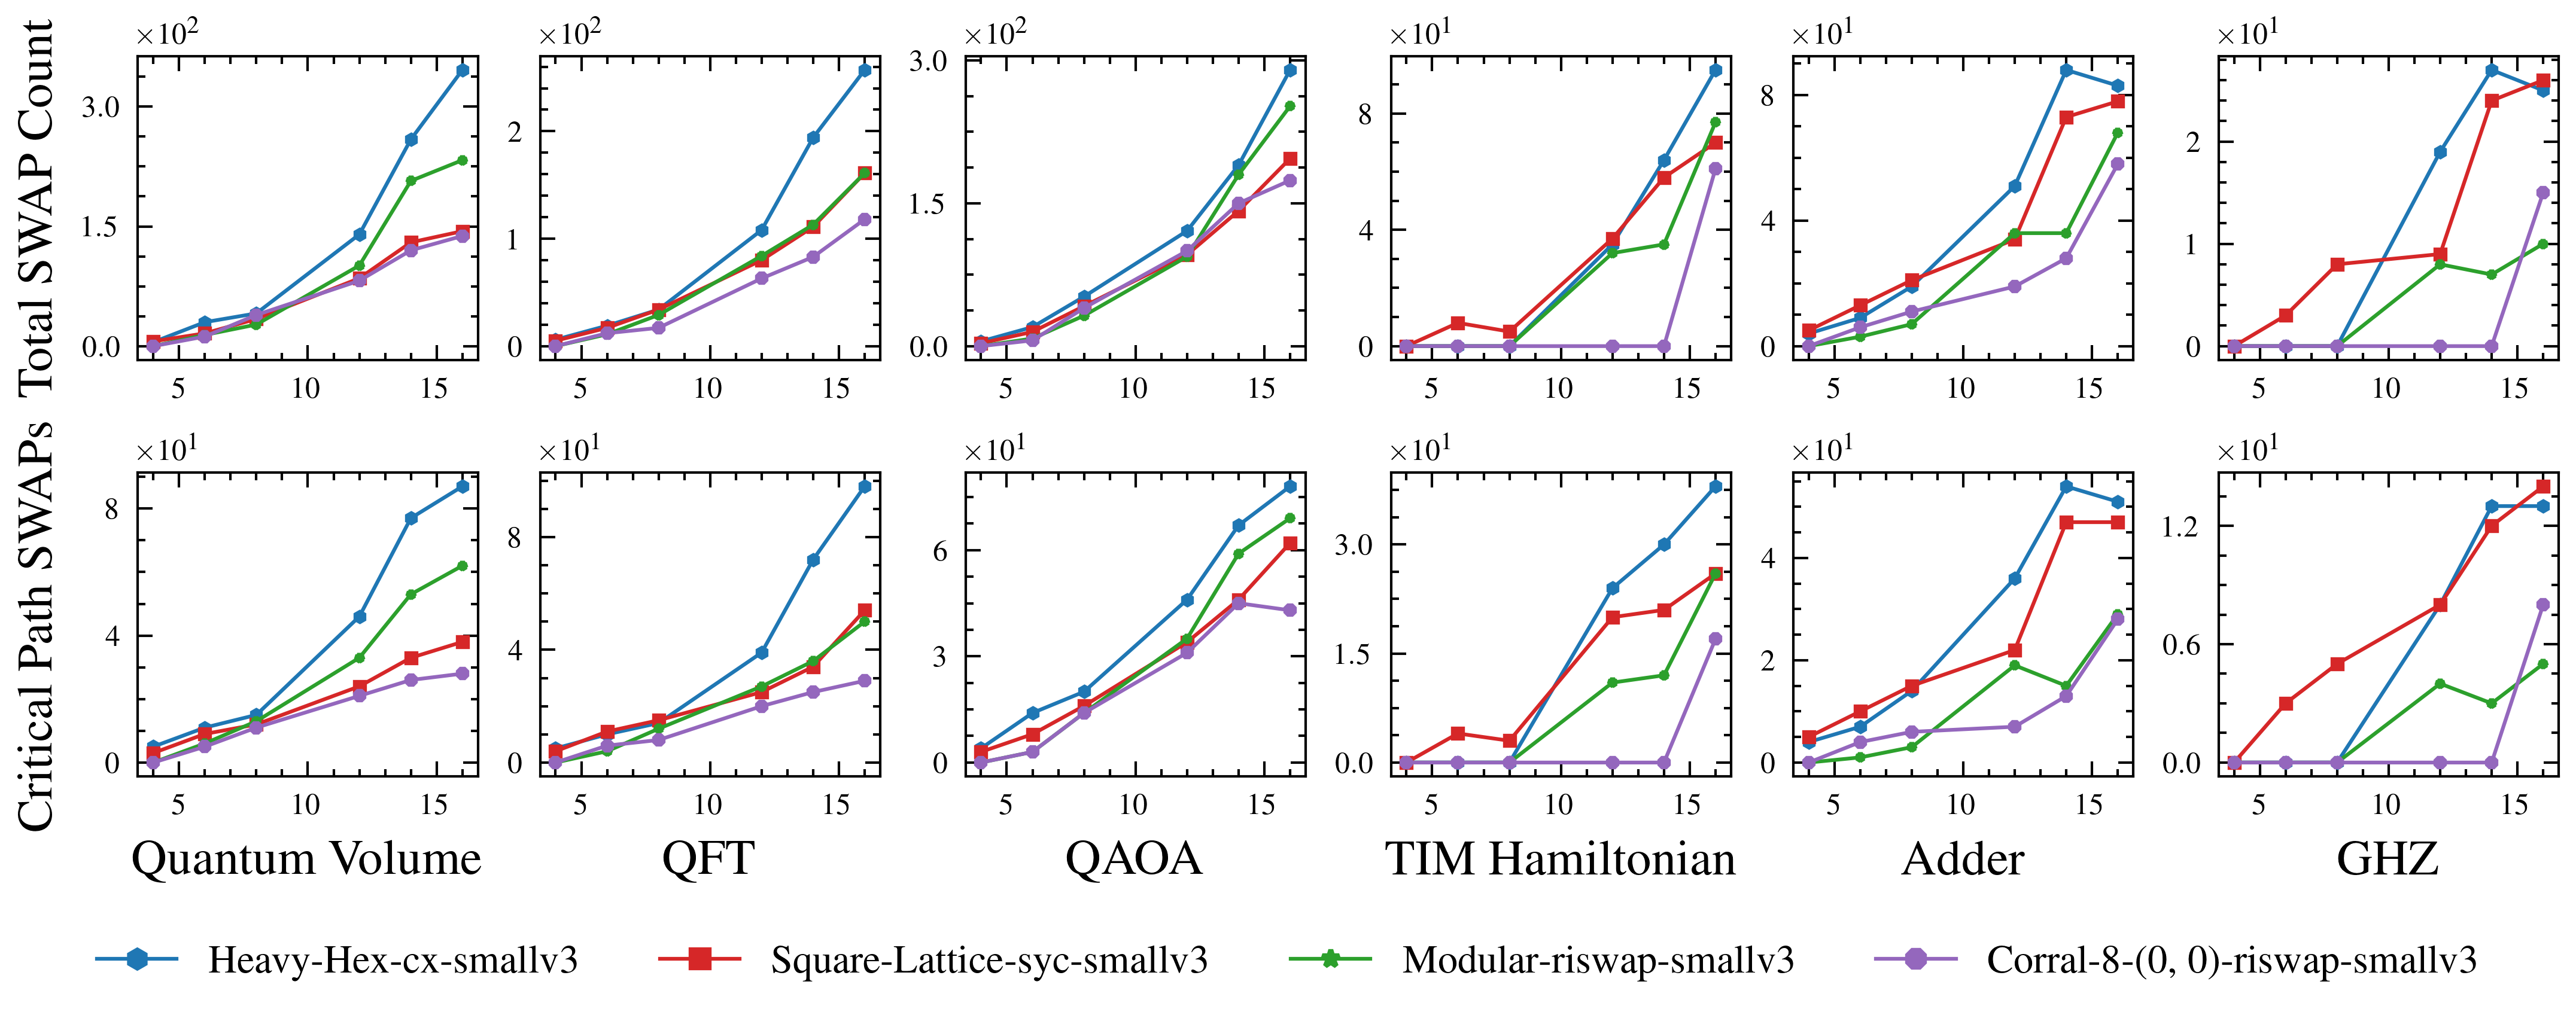

In [31]:
from src.benchmark_suite.main_plotting import benchmark, plot_wrap

for circuit_gen in circuits.values():
    benchmark(backends= simple_backends_v3, circuit_generator=circuit_gen, q_range=[4, 6, 8, 12, 14, 16], continuously_save=1, overwrite=0, repeat=1)
plot_wrap(simple_backends_v3, circuits.keys(), motivation=True, plot_average=True)

In [ ]:
#TODO: create a cell for every figure using v3, run it and time it approximately

# Approximate Decomposition

In [ ]:
# TODO